In [1]:
# project: p6
# submitter: jnovoa@wisc.edu
# partner: none
# hours: 20

In [2]:
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import rasterio
from rasterio.mask import mask
import numpy as np

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
#Q1: How many counties are in Wisconsin?
df = gpd.read_file("counties.geojson")
len(df)

matplotlib.axes._subplots.AxesSubplot

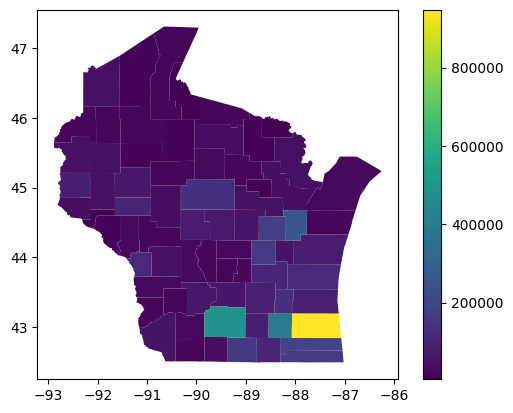

In [4]:
#Q2: What is the population of each county in WI?
type(df.plot("POP100", legend=True))

In [5]:
conn = sqlite3.connect("counties_tracts.db")
# df.to_sql("table", conn, if_exists="replace", index=False)
# pd.read_sql("""SELECT * FROM sqlite_master""", conn)
df["AREALAND"] = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
train, test = train_test_split(df, test_size=0.25,random_state=250)

In [6]:
#Q3: What are the counties in the test dataset?
list(test["NAME"])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?
xcols = ["AREALAND"]
ycol = "POP100" # good practice to assign vars for fewer bugs

model = LinearRegression()
model.fit(train[xcols], train[ycol])
#y = model.predict(test[xcols])
model.score(test[xcols], test[ycol]) # .score calls predict for us

0.016720430179409274

In [8]:
#Q5: What is the predicted population of a county with 400 square miles of area, according to the model?
# arealand is square meters
meters = (400*2.59) * 1000000
predict_df = pd.DataFrame({"AREALAND": [meters]})
predict_df["predicted population"] = model.predict(predict_df)  # TODO: use different X values
predict_df.iloc[0]["predicted population"]

90000.07422783462

In [9]:
county_hu100_df = pd.read_sql("""SELECT counties.NAME,SUM(HU100) as 
    HU100 FROM tracts INNER JOIN counties
    ON tracts.COUNTY = counties.COUNTY GROUP 
    BY counties.COUNTY""", conn)
county_hu100_dict = {} # county : SUM(hu100)
for idx in range(len(county_hu100_df)):
    county = county_hu100_df.iloc[idx]["NAME"]
    hu100 = (county_hu100_df.iloc[idx]["HU100"])
    county_hu100_dict[county] = hu100

for idx in range(len(df)):
    name = (df.iloc[idx]["NAME"])
    df.at[idx,"HU100"] = county_hu100_dict[name]
train, test = train_test_split(df, test_size=0.25,random_state=250)

In [10]:
#Q6: What are the counties in the test dataset?
test_county_list = list(test["NAME"])
test_county_list

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7: What are the HU100 values for the counties in the test dataset?
county_hu100_test_dict = {}
for county in test_county_list:
    county_hu100_test_dict[county] = county_hu100_dict[county]
county_hu100_test_dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?
scores = cross_val_score(model, train[["HU100"]], train["POP100"])
scores.mean() # want this to be large (it's not)

0.9739348181232653

In [13]:
#Q9: What is the standard deviation of the cross validation scores from Q8?
scores.std()

0.01693954236334351

In [14]:
#Q10: What is the formula relating POP100 and HU100?
#model = LinearRegression()
model.fit(train[["HU100"]], train["POP100"])
slope = model.coef_[0]
yint = model.intercept_
f"POP100 = {round(slope,2)}*HU100 + {round(yint,2)}"

'POP100 = 2.47*HU100 + -9276.89'

/home/jarednovoa/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- POP100
Feature names seen at fit time, yet now missing:
- HU100

  warnings.warn(message, FutureWarning)


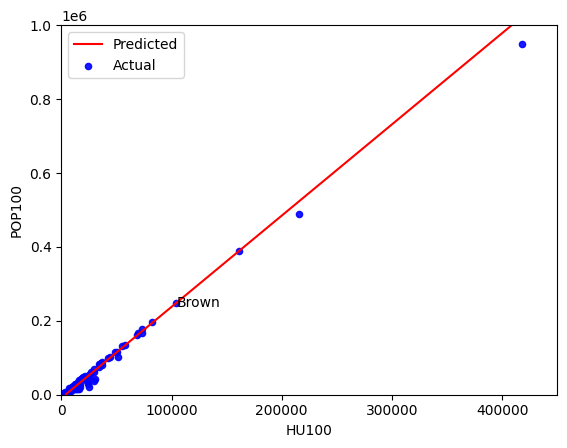

In [15]:
#Q11: What is the relationship between HU100 and POP100, visually?
# https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
for idx in range(len(df)):
    if df.iloc[idx].NAME == "Brown County":
        brown_x = df.iloc[idx]["HU100"]
        brown_y = df.iloc[idx]["POP100"]
        brown_df = df.iloc[[idx]]

pop_max = df["POP100"].max()
pop_min = df["POP100"].min()
predict_df = pd.DataFrame({"POP100": range(pop_min, pop_max, 1000)})
predict_df["HU100"] = model.predict(predict_df)
ax = predict_df.plot.line(x="POP100", y="HU100", color = "r", label = "Predicted")
df.plot.scatter(x= "HU100", y = "POP100", ax=ax, alpha = .9, color = "blue", label = "Actual")
plt.ylim(0,1e6)
plt.xlim(0,450000)
plt.xticks([0,100000,200000,300000,400000])
ax.legend(loc="upper left")
ax.text(brown_x,brown_y, "Brown", verticalalignment = "center")
plt.show()
plt.close()

In [16]:
#Q12: How many numbers in matrix A are between 3 and 6 (inclusive)?
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
((A>=3)&(A<=6)).astype(int).sum()

8

In [17]:
# brown_df = pd.DataFrame(brown_df)
brown_df

,NAME,POP100,geometry,AREALAND,HU100
64,Brown County,248007,"POLYGON ((-88.13118 44.67693, -88.13585 44.676...",1372928783,104371.0


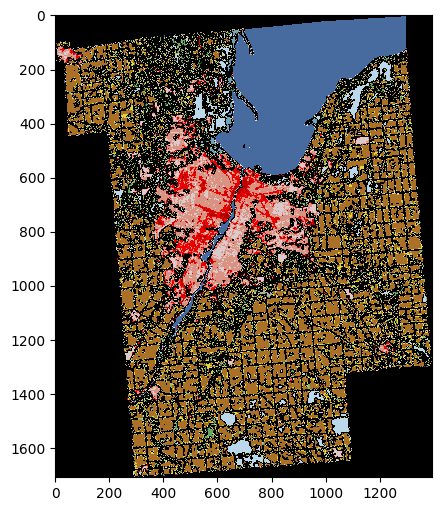

In [18]:
#Q13: How does Brown County look?
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://../p6/land.zip!wi.tif")
matrix, _ = mask(land, brown_df.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)
plt.show()
plt.close()

In [19]:
#Q14: What portion of Brown County is "Open Water"?
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
sum_open_water = ((matrix == 11) & (matrix != 0)).astype(int).sum()
sum_brown_county = ((matrix != 0)).astype(int).sum()
sum_open_water/sum_brown_county

0.13797526789725206

In [20]:
land = rasterio.open("zip://../p6/land.zip!wi.tif")
open_water_list = []

for idx in range(len(df)):
        # brown_x = df.iloc[idx]["HU100"]
        # brown_y = df.iloc[idx]["POP100"]
    county_df = df.iloc[[idx]]
    matrix, _ = mask(land, county_df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    sum_open_water = ((matrix == 11) & (matrix != 0)).astype(int).sum()
    sum_this_county = (matrix != 0).astype(int).sum()
    percent_open_water = sum_open_water/sum_this_county
    open_water_list.append(percent_open_water)
df["Percent Open Water"] = open_water_list


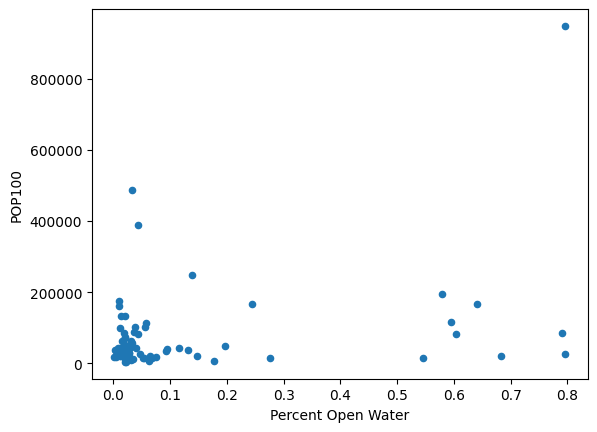

In [21]:
#Q15: What is the Relationship Between POP100 and Percent Open Water?
ax1 = df.plot.scatter(x = "Percent Open Water", y = "POP100")
plt.show()
plt.close()

In [22]:
gpd_df = gpd.read_file("tracts.shp")
new_gpd_df = gpd_df.to_crs(land.crs)

In [23]:
# gpd_df = gpd_df.to_crs(land.crs)

In [24]:
# for key in land_use.keys():  
#     # for row in df
#     list_to_add = []
#     for idx in range(len(gpd_df)):
#         row_df = gpd_df.iloc[[idx]]
#         matrix, _ = mask(land, row_df["geometry"], crop=True)
#         matrix = matrix[0]
#         sum_key = ((matrix == land_use[key]) & (matrix != 0)).astype(int).sum()
#         list_to_add.append(sum_key)
#     gpd_df[key] = list_to_add
# gpd_df

In [25]:
for key in land_use.keys():
    # init columns
    gpd_df[key] = 0
for idx in range(len(new_gpd_df)):
    row_df = new_gpd_df.iloc[[idx]]
    matrix, _ = mask(land, row_df["geometry"], crop=True)
    matrix = matrix[0]
    for key in land_use.keys():
        sum_key = ((matrix == land_use[key])).astype(int).sum()
        gpd_df.at[idx,key] = sum_key
        

<AxesSubplot:>

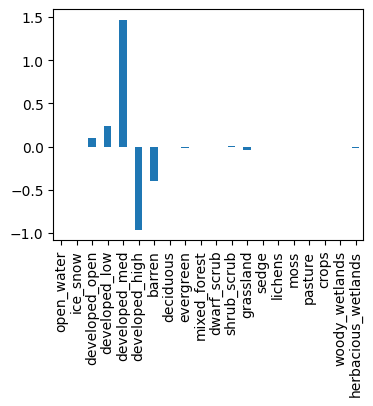

In [26]:
#Q16: What features does your model rely on most?
train, test = train_test_split(gpd_df, test_size=0.25,random_state=320)
xcols = list(land_use.keys())
ycols = "POP100"
model = LinearRegression()
model.fit(train[xcols], train[ycol])
pd.Series(model.coef_, index=xcols).plot.bar(figsize=(4,3))
# this graph is showing the how strong the correlation is between population and the particular land type

In [27]:
#Q17: How does your recommended model score against the test dataset?
model1 = LinearRegression()
xcols = ["developed_open", "developed_med", "developed_high"]
ycols = "POP100"
model1.fit(train[xcols], train[ycol])
model1_score = cross_val_score(model, train[xcols], train[ycols]).mean()

model2 = LinearRegression()
xcols = ["crops"]
ycols = "POP100"
model2.fit(train[xcols], train[ycol])
model2_score = cross_val_score(model, train[xcols], train[ycols]).mean()
# print(model1_score, model2_score)
# I recommend model1 as it demonstrates more of a relation between the factors
# developed_open, developed_med, developed_high and POP100. We can tell this because
# of the mean score that we got back from cross_val_score
# 
model1_score

0.42696860311823326